In [1]:
! git clone https://github.com/neurogym/neurogym.git
%cd neurogym/
! pip install -e .

Cloning into 'neurogym'...
remote: Enumerating objects: 13187, done.
remote: Counting objects: 100% (1489/1489), done.
remote: Compressing objects: 100% (376/376), done.
remote: Total 13187 (delta 1166), reused 1218 (delta 1098), pack-reused 11698 (from 1)
Receiving objects: 100% (13187/13187), 10.67 MiB | 7.10 MiB/s, done.
Resolving deltas: 100% (9970/9970), done.
/content/neurogym
Obtaining file:///content/neurogym
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 696.4/696.4 kB 11.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.24.1-py3-none-any.whl size=793131 sha256=a78d6bf4bd478efab2ba77168ad640f3216af1546c30d77094964cf371fb2597
  Stored in directory: /root/.cache/pip/wheels/c4/fb/19/388995b88cb551717a8dff40c889172cd12fadf994216a0a22
Successfully built gym
  Attempting uninstall: gym
    Found existi

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import time
import scipy
from scipy.spatial.distance import pdist, squareform

In [8]:
class Reg_WD(torch.nn.Module):
    def __init__(self, reg_WD=0.3, neuron_num=None, network_structure=(10, 10),
                 module_count=4, module_spacing=5, inter_module_penalty=0.05,
                 coordinates_list=None, distance_power=1, distance_metric='euclidean'):
        super(Reg_WD, self).__init__()

        self.distance_power = distance_power
        self.reg_WD = reg_WD
        self.inter_module_penalty = inter_module_penalty  # Additional penalty for inter-module connections

        # Validate network_structure
        if len(network_structure) != 2:
            raise ValueError("network_structure must have two dimensions (e.g., (rows, cols)).")

        # Calculate module dimensions
        module_rows, module_cols = network_structure
        neurons_per_module = module_rows * module_cols

        # Calculate total number of neurons
        if neuron_num is None:
            neuron_num = neurons_per_module * module_count
        else:
            if neuron_num != neurons_per_module * module_count:
                raise ValueError("The number of neurons does not match the generated coordinates.")

        # Arrange modules in a square grid
        grid_size = int(np.ceil(np.sqrt(module_count)))  # Determine grid size
        module_offsets = []
        for module_idx in range(module_count):
            row_idx = module_idx // grid_size
            col_idx = module_idx % grid_size
            offset_x = col_idx * (module_cols + module_spacing)
            offset_y = row_idx * (module_rows + module_spacing)
            module_offsets.append((offset_x, offset_y))

        # Generate neuron coordinates for each module
        coordinates = []
        module_indices = []  # To track which module each neuron belongs to
        for module_idx, (offset_x, offset_y) in enumerate(module_offsets):
            module_x, module_y = np.meshgrid(np.arange(module_cols), np.arange(module_rows))
            module_x = module_x.ravel() + offset_x
            module_y = module_y.ravel() + offset_y
            coordinates.append(np.stack([module_x, module_y]))
            module_indices.extend([module_idx] * neurons_per_module)

        # Combine coordinates from all modules
        self.coordinates = np.concatenate(coordinates, axis=1)
        self.module_indices = np.array(module_indices)

        # Override coordinates if provided
        if coordinates_list is not None:
            self.coordinates = np.array(coordinates_list)

        # Validate neuron count
        if self.coordinates.shape[1] != neuron_num:
            raise ValueError(f"The number of neurons ({neuron_num}) does not match the generated coordinates ({self.coordinates.shape[1]}).")

        # Calculate the distance matrix
        pairwise_distances = pdist(self.coordinates.T, metric=distance_metric)
        distance_matrix = squareform(pairwise_distances ** self.distance_power)

        # Identify inter-module connections
        inter_module_mask = np.zeros_like(distance_matrix, dtype=float)
        for i in range(neuron_num):
            for j in range(neuron_num):
                if self.module_indices[i] != self.module_indices[j]:
                    inter_module_mask[i, j] = self.inter_module_penalty

        # Apply inter-module penalty to the distance matrix
        self.distance_matrix = torch.tensor(distance_matrix * inter_module_mask, dtype=torch.float32)
        #self.distance_matrix = torch.tensor(distance_matrix + inter_module_mask, dtype=torch.float32)
    def forward(self, x):
        abs_weight_matrix = torch.abs(x)
        WD_loss = self.reg_WD * torch.sum(abs_weight_matrix * self.distance_matrix)
        return WD_loss

    def visualize_distance_matrix(self):
        plt.imshow(self.distance_matrix.numpy())
        plt.colorbar()
        plt.title("Distance Matrix (with Inter-Module Penalty)")
        plt.show()

    def visualize_neuron_structure(self):
        plt.scatter(self.coordinates[0], self.coordinates[1], c=self.module_indices, cmap='tab10', marker='o')
        plt.xlabel('X Coordinate')
        plt.ylabel('Y Coordinate')
        plt.title("Neuron Structure (Modules Colored)")
        plt.colorbar(label="Module Index")
        plt.show()


In [4]:
class seRNN(nn.Module):

    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        num_layers: int,
        num_classes: int,
        #device: str,
        add_noise: bool = True,
        noise_std: float = 0.05,
    ):
        super(seRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        #self.device = device
        self.add_noise = add_noise
        self.noise_std = noise_std

        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, nonlinearity='relu')
        self.output_layer = nn.Linear(hidden_size, num_classes)
        self.softmax = nn.Softmax(dim=1)



    def forward(self, x):
        if self.add_noise:
            noise = torch.randn_like(x) * self.noise_std
            x = x + noise
        rnn_output, _ = self.rnn(x)
        out = self.output_layer(rnn_output)
        return out, rnn_output


/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:69: UserWarning: WARN: Agent's minimum action space value is -infinity. This is probably too low.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:73: UserWarning: WARN: Agent's maximum action space value is infinity. This is probably too high
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


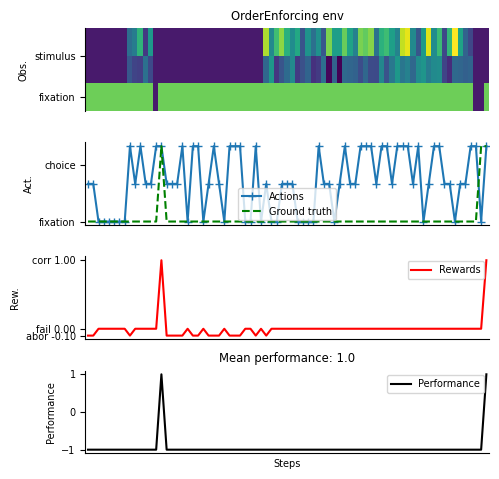

In [5]:
import neurogym as ngym

import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

# Environment
task = 'PerceptualDecisionMaking-v0'
timing = {
    'fixation': ('choice', (50, 100, 200, 400)),
    'stimulus': ('choice', (100, 200, 400, 800)),
}
kwargs = {'dt': 20, 'timing': timing}
seq_len = 100

# Make supervised dataset
dataset = ngym.Dataset(task, env_kwargs=kwargs, batch_size=16,
                       seq_len=seq_len)

# A sample environment from dataset
env = dataset.env
# Visualize the environment with 2 sample trials
_ = ngym.utils.plot_env(env, num_trials=2)

# Network input and output size
input_size = env.observation_space.shape[0]
output_size = env.action_space.n


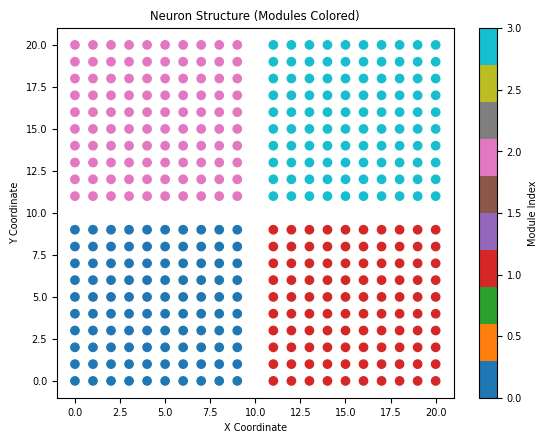

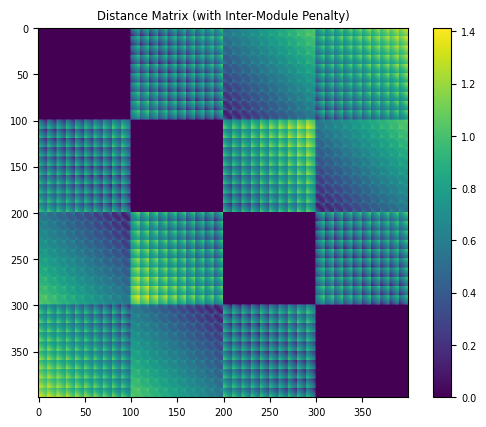

In [9]:
# Example: Create a 4-module network with 10x10 neurons per module
WD_regularizer = Reg_WD(
    reg_WD=0.5,
    network_structure=(10, 10),  # Each module has 10x10 neurons
    module_count=4,              # Total of 4 modules
    module_spacing=1             # Space between modules
)

# Visualize neuron structure
WD_regularizer.visualize_neuron_structure()

# Check the distance matrix
WD_regularizer.visualize_distance_matrix()


seRNN(
  (rnn): RNN(3, 400, batch_first=True)
  (output_layer): Linear(in_features=400, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)
Step 50, Loss: 2.2771, Time: 2.88s
Step 100, Loss: 0.4754, Time: 8.10s
Step 150, Loss: 0.2193, Time: 11.48s
Step 200, Loss: 0.1549, Time: 13.99s
Step 250, Loss: 0.1396, Time: 16.31s
Step 300, Loss: 0.1315, Time: 18.63s
Step 350, Loss: 0.1285, Time: 21.16s
Step 400, Loss: 0.1279, Time: 24.52s
Step 450, Loss: 0.1264, Time: 26.91s
Step 500, Loss: 0.1252, Time: 29.44s
Step 550, Loss: 0.1252, Time: 31.80s
Step 600, Loss: 0.1238, Time: 34.19s
Step 650, Loss: 0.1244, Time: 37.67s
Step 700, Loss: 0.1258, Time: 40.08s
Step 750, Loss: 0.1248, Time: 42.49s
Step 800, Loss: 0.1242, Time: 45.05s
Step 850, Loss: 0.1233, Time: 47.76s
Step 900, Loss: 0.1240, Time: 50.84s
Step 950, Loss: 0.1249, Time: 53.40s
Step 1000, Loss: 0.1248, Time: 55.77s


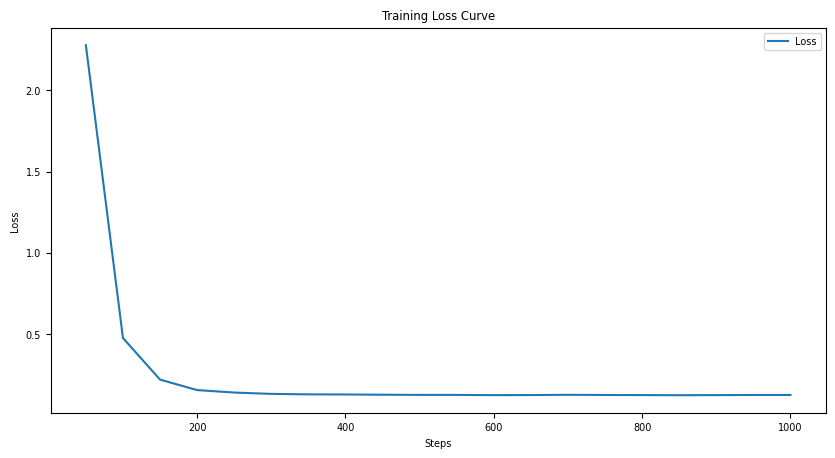

In [10]:
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import logging
import time

logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

# Assuming the seRNN class, Dataset, and other necessary elements are defined elsewhere.

# Instantiate the network
input_size = 3  # Replace with actual input size
output_size = 4  # Replace with actual output size
hidden_size = 10*10*4
net = seRNN(input_size=input_size, hidden_size=hidden_size, num_layers=1, num_classes=output_size)

# Instantiate the updated regularizer with modular neurons and inter-module spacing
WD_regularizer = Reg_WD(
    reg_WD=0.01,
    neuron_num=hidden_size,
    network_structure=(10, 10),  # Define neurons per module
    module_count=4,
    inter_module_penalty=0.01, # Number of modules
    module_spacing=1           # Spacing between modules
)

# Print model structure
print(net)

# Optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Training
loss_values = []
running_loss = 0.0
print_step = 50
steps = 1000
start_time = time.time()

train_cost = []

for i in range(steps):
    # Get batch data from dataset
    inputs, labels = dataset()
    inputs = torch.from_numpy(inputs).type(torch.float)
    labels = torch.from_numpy(labels.flatten()).type(torch.long)

    # Zero the gradients
    optimizer.zero_grad()

    # Forward pass
    output, activity = net(inputs)
    output = output.view(-1, output_size)

    # Compute the main loss
    loss = criterion(output, labels)

    # Add the modular weight distance regularization loss
    WD_cost = WD_regularizer(net.rnn.weight_hh_l0)
    loss += WD_cost

    # Backward pass and optimize
    loss.backward()
    optimizer.step()

    # Track loss
    running_loss += loss.item()

    # Print updates
    if i % print_step == (print_step - 1):
        average_loss = running_loss / print_step
        print(f"Step {i+1}, Loss: {average_loss:.4f}, Time: {time.time() - start_time:.2f}s")
        loss_values.append(average_loss)
        running_loss = 0.0

# Plot the training loss
plt.figure(figsize=(10, 5))
plt.title("Training Loss Curve")
plt.plot(np.arange(print_step, steps + print_step, print_step), loss_values, label="Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()


<ipython-input-12-ed12191be33f>:38: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(WD_regularizer.coordinates[0], WD_regularizer.coordinates[1],


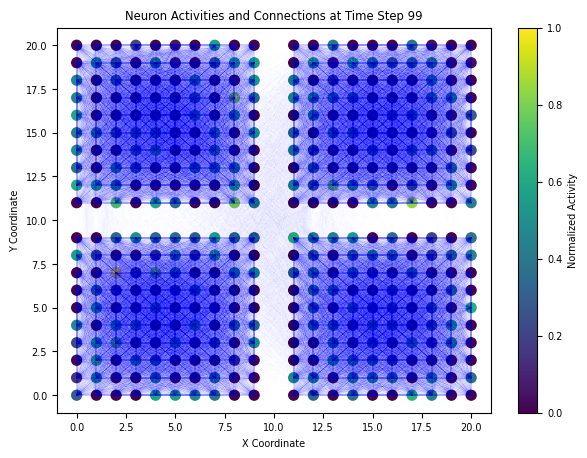

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming WD_regularizer, net, and activity are already defined and available

# Choose a specific time step to visualize activity
time_step = 99  # Example: visualize activity at time step 50

# Extract neuron activities at the chosen time step
neuron_activities = activity[time_step, 0, :].detach().numpy()  # Assuming activity is for a single batch

# Normalize neuron activities for color mapping
normalized_activities = (neuron_activities - neuron_activities.min()) / (neuron_activities.max() - neuron_activities.min())

# Create a colormap based on normalized activities
colors = plt.cm.viridis(normalized_activities)

# Get recurrent kernel weights
recurrent_kernel = net.rnn.weight_hh_l0.detach().numpy()


# Create a 2D plot
plt.figure(figsize=(7, 5))  # Adjust figure size as needed

# Plot neurons with color representing activity
#plt.scatter(WD_regularizer.coordinates[0], WD_regularizer.coordinates[1],
#            c=colors, marker='o', s=50, cmap='viridis')  # Adjust marker size and cmap as needed

# Plot connections between neurons
for i in range(recurrent_kernel.shape[0]):
    for j in range(recurrent_kernel.shape[1]):
        weight = recurrent_kernel[i, j]
        #print(weight)
        if abs(weight) > 0:  # Threshold for displaying connections
            x1, y1 = WD_regularizer.coordinates[0][i], WD_regularizer.coordinates[1][i]
            x2, y2 = WD_regularizer.coordinates[0][j], WD_regularizer.coordinates[1][j]
            plt.plot([x1, x2], [y1, y2], color='blue', linewidth=abs(weight), alpha=0.5)  # Adjust linewidth and alpha as needed
plt.scatter(WD_regularizer.coordinates[0], WD_regularizer.coordinates[1],
            c=colors, marker='o', s=50, cmap='viridis')  # Adjust marker size and cmap as needed
#print(f"Recurrent kernel shape: {recurrent_kernel.shape}")
#print(f"Number of coordinates: {len(WD_regularizer.coordinates[0])}")
# Set plot labels and title
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title(f'Neuron Activities and Connections at Time Step {time_step}')
plt.colorbar(label='Normalized Activity')  # Add colorbar with label

plt.show()

In [11]:
# @title Run the network post-training and record neural activity

env.reset(no_step=True)
env.timing.update({'fixation': ('constant', 500),
                   'stimulus': ('constant', 500)})
perf = 0
num_trial = 500

activity_dict = {}

trial_infos = {}

stim_activity = [[], []]  # response for ground-truth 0 and 1


for i in range(num_trial):
    env.new_trial()
    #env.new_trial()

    ob, gt = env.ob, env.gt
    inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)

    action_pred, rnn_activity = net(inputs)
    action_pred = action_pred.detach().numpy()
    choice = np.argmax(action_pred[-1, 0, :])
    correct = choice == gt[-1]
    trial_info = env.trial
   # print(trial_info_sparse)
    trial_info.update({'correct': correct, 'choice': choice})
    trial_infos[i] = trial_info

    rnn_activity = rnn_activity[:, 0, :].detach().numpy()
    activity_dict[i] = rnn_activity

    rnn_activity = rnn_activity[env.start_ind['stimulus']: env.end_ind['stimulus']]
    stim_activity[env.trial['ground_truth']].append(rnn_activity)

print(trial_infos.values())

print('Average performance for sparse RNN', np.mean([val['correct'] for val in trial_infos.values()]))



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


dict_values([{'ground_truth': 1, 'coh': 0.0, 'correct': True, 'choice': 2}, {'ground_truth': 0, 'coh': 12.8, 'correct': False, 'choice': 2}, {'ground_truth': 1, 'coh': 51.2, 'correct': True, 'choice': 2}, {'ground_truth': 1, 'coh': 51.2, 'correct': True, 'choice': 2}, {'ground_truth': 1, 'coh': 0.0, 'correct': True, 'choice': 2}, {'ground_truth': 1, 'coh': 6.4, 'correct': True, 'choice': 2}, {'ground_truth': 1, 'coh': 51.2, 'correct': True, 'choice': 2}, {'ground_truth': 1, 'coh': 12.8, 'correct': True, 'choice': 2}, {'ground_truth': 0, 'coh': 0.0, 'correct': False, 'choice': 2}, {'ground_truth': 0, 'coh': 0.0, 'correct': False, 'choice': 2}, {'ground_truth': 1, 'coh': 6.4, 'correct': True, 'choice': 2}, {'ground_truth': 1, 'coh': 51.2, 'correct': True, 'choice': 2}, {'ground_truth': 1, 'coh': 25.6, 'correct': True, 'choice': 2}, {'ground_truth': 0, 'coh': 12.8, 'correct': False, 'choice': 2}, {'ground_truth': 1, 'coh': 25.6, 'correct': True, 'choice': 2}, {'ground_truth': 1, 'coh': 12

Text(0, 0.5, 'Activity')

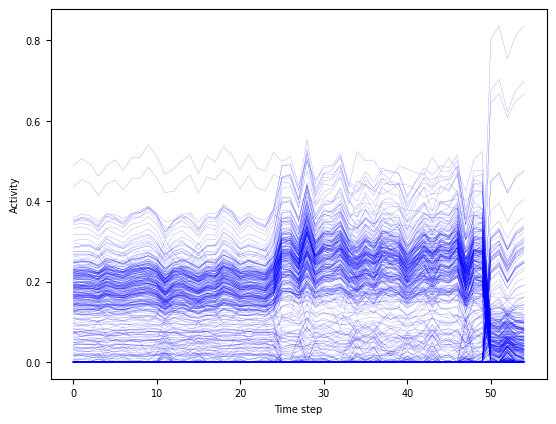

In [77]:
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)


import matplotlib.pyplot as plt

trial = 2

plt.figure()
_ = plt.plot(activity_dict[trial], color='blue', label='Excitatory',linewidth = 0.1)
plt.xlabel('Time step')
plt.ylabel('Activity')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Shape of the neural activity (Time points, Neurons): (27500, 400)
Shape of the projected activity (Time points, PCs): (27500, 2)


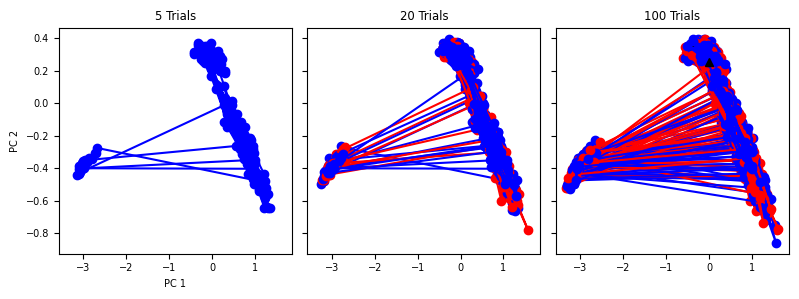

In [35]:
# Import necessary libraries
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import logging

logging.getLogger("matplotlib").setLevel(logging.CRITICAL)

num_trial = 500  # Number of trials to analyse

### Play with different values here to understand the dynamics
plot_until_time = 70



# Concatenate activity data across all trials for PCA
activity = np.concatenate([activity_dict[i] for i in range(num_trial)], axis=0)
print('Shape of the neural activity (Time points, Neurons):', activity.shape)

# Initialize PCA and fit it on the activity data
pca = PCA(n_components=2)
# Using 2 components for visualization
pca.fit(activity)
activity_pc = pca.transform(activity)
# Transform to lower dimensions (2D) - hint ".transform" could he helpful
print('Shape of the projected activity (Time points, PCs):', activity_pc.shape)

# Visualization
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(8, 3))

# Plot all trials in ax1 and fewer trials in ax2 for clarity
for i in range(100):
    # Transform and plot each trial
    activity_pc = pca.transform(activity_dict[i])  # Project each trial's activity

    # Color by ground truth
    trial = trial_infos[i]
    color = 'red' if trial['ground_truth'] == 0 else 'blue'
    if i < 5:  # Fewer trials in ax2 for clear visualization
        ax1.plot(activity_pc[:plot_until_time, 0], activity_pc[:plot_until_time, 1], 'o-', color=color)
    if i < 20:  # Fewer trials in ax2 for clear visualization
        ax2.plot(activity_pc[:plot_until_time, 0], activity_pc[:plot_until_time, 1], 'o-', color=color)

    ax3.plot(activity_pc[:plot_until_time, 0], activity_pc[:plot_until_time, 1], 'o-', color=color)
    #if i < 3:  # Fewer trials in ax2 for clear visualization
       # ax2.plot(activity_pc[:plot_until_time, 0], activity_pc[:plot_until_time, 1], 'o-', color=color)

    # Indicate trial start with a different marker
    ax3.plot(activity_pc[0, 0], activity_pc[0, 1], '^', color='black')

# Setting labels and titles for clarity
ax1.set_title('5 Trials')
ax2.set_title('20 Trials')
ax3.set_title('100 Trials')
ax1.set_xlabel('PC 1')
ax1.set_ylabel('PC 2')

plt.tight_layout()
plt.show()


In [65]:
# @title Compute stimulus selectivity for sorting neurons

# Here for each neuron we compute its stimulus period selectivity

mean_activity = []
std_activity = []
for ground_truth in [0, 1]:
    activity = np.concatenate(stim_activity[ground_truth], axis=0)
    mean_activity.append(np.mean(activity, axis=0))
    std_activity.append(np.std(activity, axis=0))

# Compute d'
selectivity = (mean_activity[0] - mean_activity[1])
selectivity /= np.sqrt((std_activity[0]**2+std_activity[1]**2+1e-7)/2)

# Sort index for selectivity, separately for E and I
ind_sort = np.concatenate((np.argsort(selectivity),
                           np.argsort(selectivity)))


Text(0.5, 1.0, 'Network connectivity')

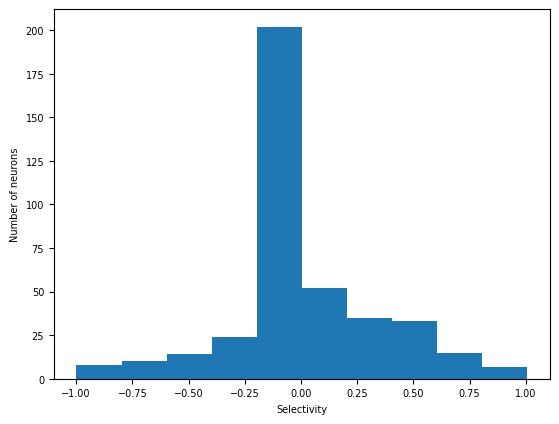

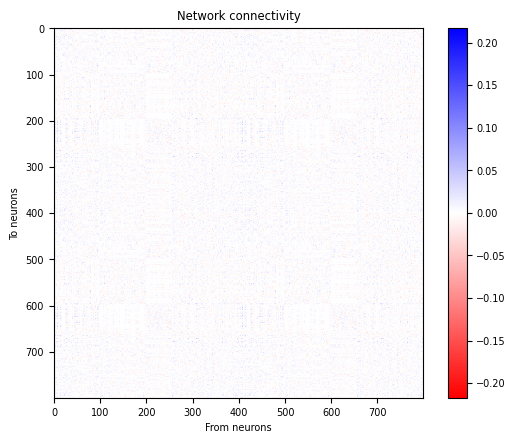

In [71]:
# @title Plot network connectivity sorted by stimulus selectivity

# import warnings
# warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

# Plot distribution of stimulus selectivity
plt.figure()
plt.hist(selectivity)
plt.xlabel('Selectivity')
plt.ylabel('Number of neurons')

W = net.rnn.weight_hh_l0.detach().numpy()
# Sort by selectivity
W = W[:, ind_sort][ind_sort, :]
wlim = np.max(np.abs(W))
plt.figure()
plt.imshow(W, cmap='bwr_r', vmin=-wlim, vmax=wlim)
plt.colorbar()
plt.xlabel('From neurons')
plt.ylabel('To neurons')
plt.title('Network connectivity')